In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
import sys
sys.path.append('../')  # Add the parent folder to the Python path

from sql_functions import get_dataframe  # Import the function

main_cities = [
    "New York, NY",
    "Boston, MA",
    "Washington, DC",
    "Newark, NJ",
]

side_cities = [
    "Miami, FL",
    "Houston, TX",
    "San Francisco, CA",
    "Seattle, WA"
]


In [2]:
flights_2015 = get_dataframe('SELECT * FROM group3.flights_2015')
flights_2016 = get_dataframe('SELECT * FROM group3.flights_2016')
flights_2017 = get_dataframe('SELECT * FROM group3.flights_2017')

In [23]:
flights_2016['cancelled'] = flights_2016['cancelled'].astype(int)

flights_2015_dec = flights_2015[flights_2015['month'] == 12]

# Concatenando os DataFrames de 2016 e dezembro de 2015
flights_2016_2015 = pd.concat([flights_2015_dec, flights_2016], ignore_index=True)

# Agrupando os dados por ano e mês e calculando o número de voos cancelados e atrasados
monthly_counts = flights_2016_2015.groupby(['year', 'month']).agg({
    'cancelled': 'sum',
    'had_delay': 'sum'
}).reset_index()

monthly_counts

,year,month,cancelled,had_delay
0,2015,12,2025.0,107928
1,2016,1,2735.0,108530
2,2016,2,2153.0,110049
3,2016,3,1278.0,116176
4,2016,4,1165.0,118995
5,2016,5,1005.0,122218
6,2016,6,1906.0,114258
7,2016,7,3356.0,112922
8,2016,8,2173.0,116617
9,2016,9,616.0,120097


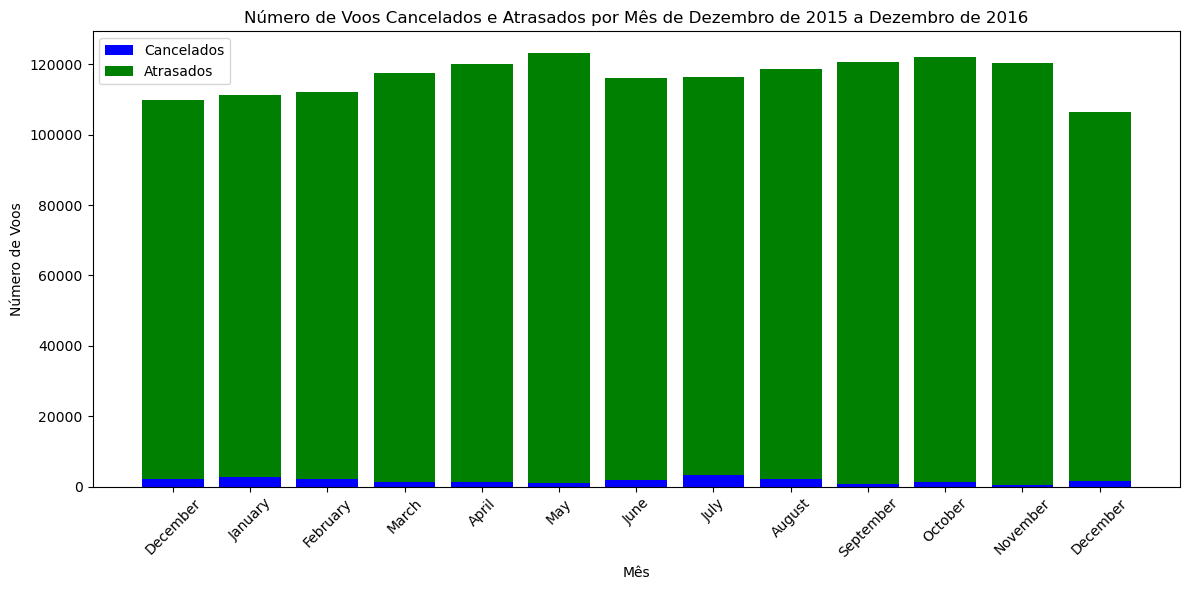

In [21]:


# Mapeando números de meses para os nomes dos meses
monthly_counts['month_name'] = monthly_counts['month'].apply(lambda x: calendar.month_name[x])

# Definindo cores específicas para cancelamentos e atrasos
colors_cancelled = ['blue'] * 13 + ['red']  # Dezembro de 2015 com cor azul, outros meses com cor azul
colors_delay = ['green'] * 13 + ['pink'] # Todos os meses com cor verde

# Plotagem do gráfico de barras
plt.figure(figsize=(12, 6))

# Plotando as barras de cancelamentos
plt.bar(range(len(monthly_counts)), monthly_counts['cancelled'], color=colors_cancelled, label='Cancelados')
# Plotando as barras de atrasos
plt.bar(range(len(monthly_counts)), monthly_counts['had_delay'], bottom=monthly_counts['cancelled'], color=colors_delay, label='Atrasados')

plt.title('Número de Voos Cancelados e Atrasados por Mês de Dezembro de 2015 a Dezembro de 2016')
plt.xlabel('Mês')
plt.ylabel('Número de Voos')
plt.xticks(range(len(monthly_counts)), monthly_counts['month_name'], rotation=45)  # Definindo os rótulos do eixo x como os nomes dos meses
plt.legend()
plt.tight_layout()
plt.show()